# Amazon Food Reviews Analysis : Data Wrangling


![alt](6641e315-5298-11e7-ba36-bdfb5d601273.jpg)

In [8]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame, datetime
from subprocess import check_output
from datetime import datetime, timedelta, time
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as cm
import seaborn as sns

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

def display (text, title):
    print(title)
    print("\n-----------------\n")
    print(text)

# 1. Data Preparation 

## Clean Numeric Data
+ Variable Identification
+ Clean missing value
+ Check duplicate reviews 
+ Main insightes from numerical data 

### Findings 
+ 1. Over 80% of reviews are rated as 4 start or 5 start, positive reviews are very common.<br>
+ 2. 

In [5]:
amazon = pd.read_csv('Reviews.csv',index_col=0)
amazon.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


+ Id
+ ProductId - unique identifier for the product
+ UserId - unqiue identifier for the user
+ ProfileName
+ HelpfulnessNumerator - number of users who found the review helpful
+ HelpfulnessDenominator - number of users who indicated whether they found the review helpful
+ Score - rating between 1 and 5
+ Time - timestamp for the review
+ Summary - brief summary of the review
+ Text - text of the review

In [6]:
#check number of observations and row
print (amazon.shape)

(568454, 9)


In [7]:
#check data type
amazon.dtypes

ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [8]:
#check missing value 
amazon.isnull().sum()

ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   26
Text                       0
dtype: int64

In [9]:
# Since majority of data has value, we can just remove missing values
amazon= amazon.dropna(subset=['ProfileName','Summary'])
amazon.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [10]:
#check number of observations and row after removed missing value
print (amazon.shape)

(568412, 9)


In [22]:
# check 
amazon.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,year,Helpful_pct
count,568412.000000,568412.000000,568412.000000,5.684120e+05,568412.000000,568412.000000
mean,1.743871,2.227872,4.183307,1.296261e+09,2010.583003,0.407883
std,7.636774,8.288745,1.310368,4.803790e+07,1.531721,0.462073
min,0.000000,0.000000,1.000000,9.393408e+08,1999.000000,0.000000
25%,0.000000,0.000000,4.000000,1.271290e+09,2010.000000,0.000000
50%,0.000000,1.000000,5.000000,1.311120e+09,2011.000000,0.000000
75%,2.000000,2.000000,5.000000,1.332720e+09,2012.000000,1.000000
max,866.000000,923.000000,5.000000,1.351210e+09,2012.000000,3.000000


In [23]:
chk1=amazon.loc[amazon.HelpfulnessDenominator==923]
chk1

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date_time,date,date1,year,Helpful_pct,help1
Id,,,,,,,,,,,,,,,
207713,B00012182G,A1JUGIQDY6UYSM,"BabbChuck ""BabbChuck""",844,923,3,1252368000,Whole Rabbit - NOT!,"I ordered one of these Fresh ""Whole"" Rabbits, ...",2009-09-08,2009-09-08,2009-09-08,2009,0.91441,75


In [11]:
# covert time
amazon['date_time']=pd.to_datetime(amazon['Time'],unit='s')
amazon['date']=pd.to_datetime(amazon['date_time'],unit='d')
amazon['date1'] = pd.to_datetime(amazon['date'])
amazon['year']=amazon.date1.dt.year
amazon.date_time.describe()

count                  568412
unique                   3168
top       2012-10-16 00:00:00
freq                     1143
first     1999-10-08 00:00:00
last      2012-10-26 00:00:00
Name: date_time, dtype: object

In [12]:
# check HelpfulnessDenominator
amazon.HelpfulnessDenominator.describe()

count    568412.000000
mean          2.227872
std           8.288745
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         923.000000
Name: HelpfulnessDenominator, dtype: float64

In [13]:
# check percentage of Helpful
amazon['Helpful_pct'] = amazon['HelpfulnessNumerator'] / amazon['HelpfulnessDenominator']
amazon.loc[amazon.HelpfulnessDenominator==0,'Helpful_pct']=0
amazon['Helpful_pct'].describe()

count    568412.000000
mean          0.407883
std           0.462073
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: Helpful_pct, dtype: float64

In [14]:
# divided the reviews into four categories
def partition(x):
    if x >=0.75:
        return '75'
    elif x>=0.5:
        return '50'
    elif x>=0.25 :
        return '25'
    return '0'
amazon['help1'] = amazon['Helpful_pct'].map(partition)
amazon['help1'].describe()

count     568412
unique         4
top            0
freq      308295
Name: help1, dtype: object

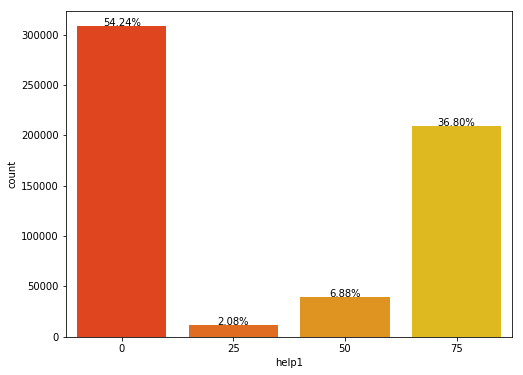

In [15]:
plt.figure(figsize=(8,6))
total = float(len(amazon)) 
ax = sns.countplot(x="help1",palette='autumn', data=amazon) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 
plt.show()

#### Among all reviews, more then 50% are not voted on at all. More than 35% of voters find the review helpful.

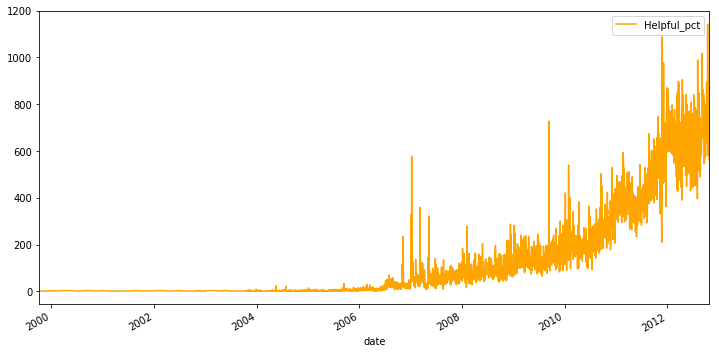

In [16]:
## Helpfulness count, reviews has increased 
time1=amazon[['date','Helpful_pct']].copy()
time1['Helpful_pct']=amazon.groupby(['date']).Helpful_pct.transform('count')
time1.set_index(['date'],inplace=True)
time1.sort_index(inplace=True)
time1.plot(color='orange',figsize=(12,6))
plt.show()

#### 1. After remove missing value the dataset contains 568,412 food reviews from Amazon users left from 1999 Oct to 2012 Oct. <BR> 2. Reviews has increased over years.

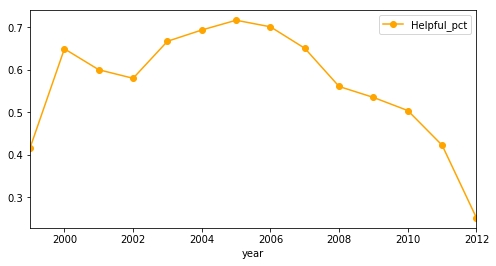

In [17]:
avg_help_pct=amazon.groupby(['year']).Helpful_pct.mean().reset_index().sort_values(by='year')
avg_help_pct.plot(x='year',y='Helpful_pct',marker='o', color='orange',figsize=(8,4))
plt.show()

### Distribution of score

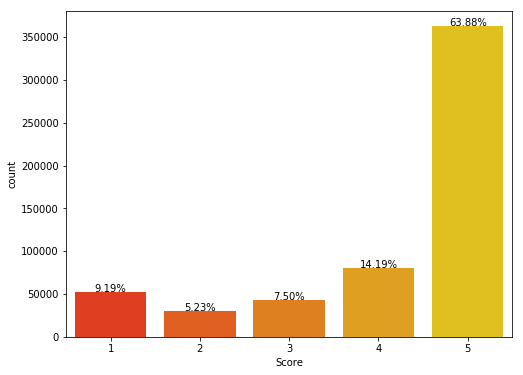

In [18]:
plt.figure(figsize=(8,6))
total = float(len(amazon)) 
ax = sns.countplot(amazon['Score'],color="orange",palette='autumn') 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 
plt.show()

In [19]:
print("Average Score: ",np.mean(amazon.Score))
print("Median Score: ",np.median(amazon.Score))

Average Score:  4.183307178595808
Median Score:  5.0


#### The distribution of rating among all of the reviews. We see that 5-star reviews constitute a large proportion (64%) of all reviews. The next most prevalent rating is 4-stars(14%), followed by 1-star (9%), 3-star (8%), and finally 2-star reviews (5%). Majority of Scores are around 4 to 5, and average score is 4.18. The distribution is very skewed to the left. 

#### Summary of dataset statistics 
+ Number of reviews : 393,566
+ Number of unique users : 256,048 
+ Number of unique products :74,258

In [20]:
review= amazon['UserId'].groupby(amazon['Text']).count()
print(review.count())
User= amazon['Score'].groupby(amazon['UserId']).count()
print(User.count())
products = amazon['Score'].groupby(amazon['ProductId']).count()
print(products.count())

393566
256048
74258


In [18]:
amazon['chk']=amazon.duplicated(['Text'])
amazon['chk'].sum()

174846

#### In order to conudct the modeling,  we need to have the target value to determine if a given review text is helpful or not.  The chosen method is to use a threshold of 'helpful_numerator' divided by 'helpful_denominator'. 
#### In other words, the ratio of the people who found the review helpful over the amount of people who rated the review as helpful or unhelpful. If this ratio exceeds a certain threshold value, we can label the data as 'helpful' = 1, or 'non-helpful' = 0. For this analysis, the threshold is arbitrarily set to 0.7.

In [62]:
#set up target variable -transform Helpfulness into a binary variable
threshold = 0.7
amazon.loc[:, 'Helpful'] = np.where(amazon.loc[:, 'HelpfulnessNumerator'] \
                                 / amazon.loc[:, 'HelpfulnessDenominator'] > threshold, 1, 0)
amazon.head(2)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date_time,date,date1,year,Helpful_pct,help1,Summary1,text_Clean1,text_Clean2,word_cnt,Helpful
Id,,,,,,,,,,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011-04-27,2011-04-27,2011,1.0,75,good quality dog food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,48,1
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012-09-07,2012-09-07,2012,0.0,0,advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...,31,0


## Clean Text
+ Remove noisy : html tagging
+ Remove stopwords, punctuation
+ Text visualization

+ Stemming - Stemming means to take off the suffixes of the stemmed word. Therefore words such as "run" and "running" would both be represented as "run". 
+ Tolkenizing- Splits sentences up into single words. This is needed to generate our TFIDF features later.
+ Remove Stop Words- This moves words such as "the" "a" and "it" as shown in the English stop words corpus. These will only clutter up our learning algorithm. Admittingly, sentences without these words are hard to understand, and ideally they should be kept, but it is again a trade-off.

In [24]:
from bs4 import BeautifulSoup 
from scipy.misc import imread
from PIL import Image
import numpy as np
import re
import matplotlib as mpl
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mirabooboo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mirabooboo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
chk1=amazon["Text"][28]
display(chk1,'sample check')

sample check

-----------------

I was so glad Amazon carried these batteries.  I have a hard time finding them elsewhere because they are such a unique size.  I need them for my garage door opener.<br />Great deal for the price.


In [29]:
def clean_text1(text, remove_stopwords = True):
    '''Remove stopwords'''
    
    # Convert words to lower case
    text = text.lower()
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        
    return text

In [30]:
amazon["Summary1"] = amazon["Summary"].apply(clean_text1)

In [31]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [32]:
c_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expandContractions(text, c_re=c_re):
    def replace(match):
        return contractions[match.group(0)]
    return c_re.sub(replace, text)

In [33]:
sample=amazon["Text"][29]
expandContractions(sample) # need to remove html tagging<br/>

'I got this for my Mum who is not diabetic but needs to watch her sugar intake, and my father who simply chooses to limit unnecessary sugar intake - she is the one with the sweet tooth - they both LOVED these toffees, you would never guess that they are sugar-free and it is so great that you can eat them pretty much guilt free!  i was so impressed that i have ordered some for myself (w dark chocolate) to take to the office so i will eat them instead of snacking on sugary sweets.<br />These are just EXCELLENT!'

In [34]:
amazon["text_Clean1"] = amazon["Text"].apply(expandContractions)

In [35]:
lemmatizer = nltk.WordNetLemmatizer()
stemmer = PorterStemmer()
stop = stopwords.words('english')
def clean_text2(line):
    tokens=[]
    line= BeautifulSoup(line, 'html.parser').get_text()
    line= re.sub(r'\<a href', ' ', line)
    line= re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', line)
    line= re.sub(r'&amp;', '', line) 
    line= re.sub(r"\'s", " is", line)
    line= nltk.word_tokenize(line.lower())
    for w in line:
        if(w not in stop):
#             stemmed = stemmer.stem(w)
            stemmed = lemmatizer.lemmatize(w)
            tokens.append(stemmed)
    return ' '.join(tokens)

In [36]:
amazon["text_Clean2"] = amazon["text_Clean1"].apply(clean_text2)

In [37]:
chk2=amazon["text_Clean2"][29]
display(chk2,'sample check')

sample check

-----------------

got mum diabetic need watch sugar intake father simply chooses limit unnecessary sugar intake one sweet tooth loved toffee would never guess sugar free great eat pretty much guilt free impressed ordered w dark chocolate take office eat instead snacking sugary sweet excellent


In [38]:
amazon["word_cnt"] = amazon['Text'].str.split().str.len()
amazon["word_cnt"].describe()

count    568412.000000
mean         80.267303
std          79.457074
min           3.000000
25%          33.000000
50%          56.000000
75%          98.000000
max        3432.000000
Name: word_cnt, dtype: float64

#### Each review contains approximately 80 words.

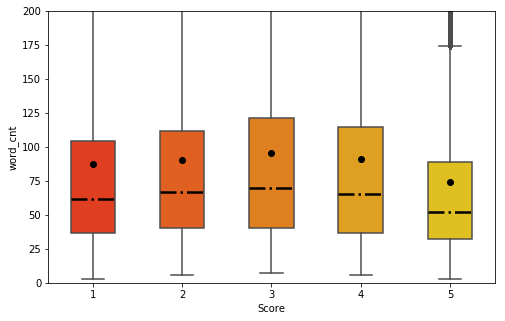

In [63]:
medianprops = dict(linestyle='-.', linewidth=2.5, color='black')
meanprops = dict(linestyle='none', marker='o', markerfacecolor='black',markeredgecolor='black')
plt.figure(figsize=(8,5))
plt.ylim(0, 200)
# Change line width
sns.boxplot( x=amazon["Score"], y=amazon["word_cnt"], showmeans=True, meanprops=meanprops, medianprops=medianprops, width=0.5,palette='autumn')
plt.show()

#### 5-star reviews had the lowest median word count and 3-star reviews had the largest median word count.

In [63]:
# save clean data 
amazon.to_csv('amazon_clean.csv')

## Word cloud for all reviews

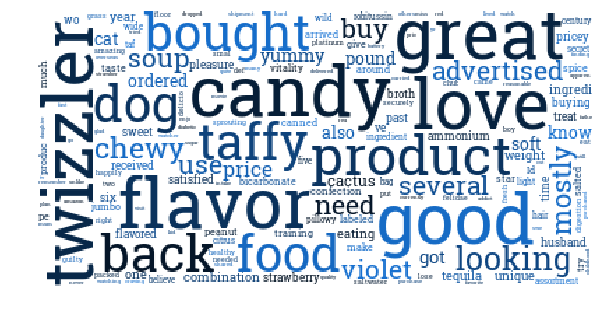

In [59]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 150.0 / 255.0)
    s = int(100.0 * 205.0 / 255.0)
    l = int(100.0 * float(random_state.randint(20, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

from collections import Counter
import random
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from os import path
import os
mpl.rcParams['font.size']=12                
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        font_path=os.path.join('fonts', 'RobotoSlab-Regular.ttf'),
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=50, 
        color_func=random_color_func
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(10, 6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
#     plt.imshow(wordcloud.)
show_wordcloud(amazon["text_Clean2"]) 

## Low Score reviews word cloud 

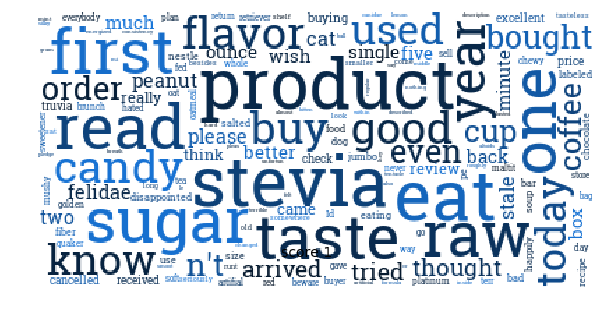

In [60]:
show_wordcloud(amazon[amazon.Score == 1]["text_Clean2"], title = "score 1")

## High Score reviews word cloud

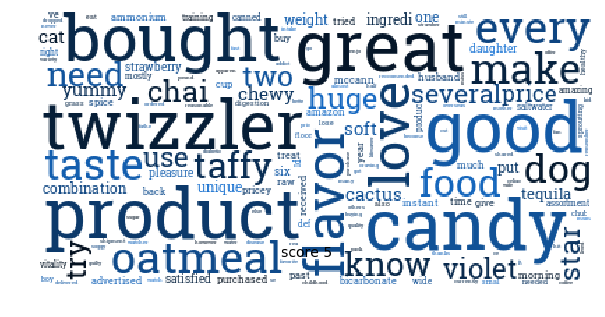

In [61]:
show_wordcloud(amazon[amazon.Score == 5]["text_Clean2"], title = "score 5")

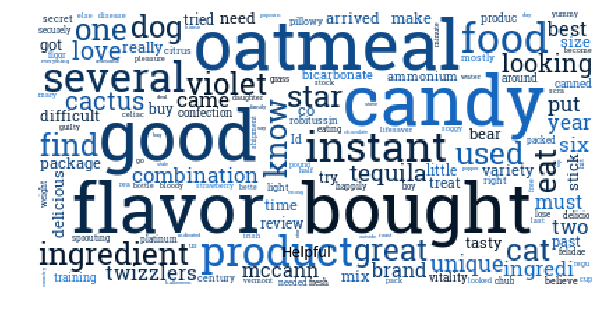

In [64]:
show_wordcloud(amazon[amazon.Helpful == 1]["text_Clean2"], title = "Helpful")

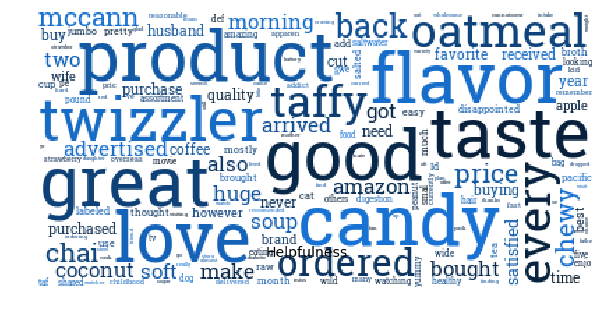

In [65]:
show_wordcloud(amazon[amazon.Helpful == 0]["text_Clean2"], title = "Helpfulness")

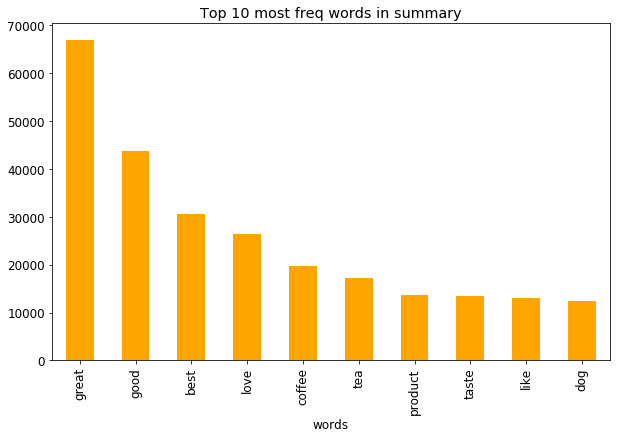

In [43]:
word_his = pd.DataFrame(Counter(" ".join(amazon['Summary1']).split()).most_common(10),columns=['words','count'])
word_his.plot(kind='bar',x=word_his['words'],legend=False,title='Top 10 most freq words in summary',figsize=(10,6), color="orange")
plt.show()

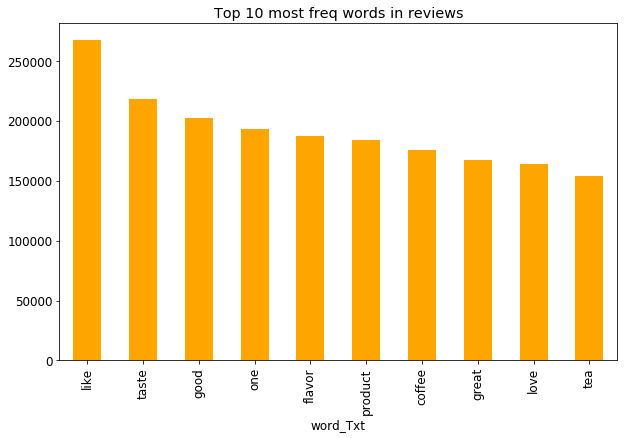

In [44]:
word_Txt_his = pd.DataFrame(Counter(" ".join(amazon['text_Clean2']).split()).most_common(10),columns=['word_Txt','count'])
word_Txt_his.plot(kind='bar',x=word_Txt_his['word_Txt'],legend=False,title='Top 10 most freq words in reviews',figsize=(10,6), color="orange")
plt.show()

#### Further analysis : <br> Does the behavior of frequent reviewers differ from that of infrequent reviewers?